In [7]:
import sys

sys.path.append("../src")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.linalg import eigh
import sto_ng
import sto_ng_overlap_function
import h5py
import gaussian_overlap_function


importlib.reload(sto_ng)
importlib.reload(sto_ng_overlap_function)
importlib.reload(gaussian_overlap_function)
from sto_ng import *
from sto_ng_overlap_function import *
from gaussian_overlap_function import *

In [9]:
with h5py.File("sto_ng.h5", "r") as f:
    alphas = f["1s/sto-3g/alpha"][:]
    cs = f["1s/sto-3g/c"][:]
alphas = np.array(alphas)
cs = np.array(cs)
cs_new = cs * (2 * alphas / np.pi) ** (3 / 4)

In [10]:
def energy_2e(zeta, alphas, cs, RA):
    scaled_alphas = alphas * zeta**2
    U_mat = GaussianOverlapFunction.U(
        scaled_alphas[:, None, None, None],
        scaled_alphas[None, :, None, None],
        scaled_alphas[None, None, :, None],
        scaled_alphas[None, None, None, :],
        RA,
        RA,
        RA,
        RA,
    )
    norm = (
        cs_new
        @ GaussianOverlapFunction.S(
            scaled_alphas[:, None], scaled_alphas[None, :], RA, RA
        )
        @ cs_new
    )

    Uc = np.tensordot(U_mat, cs, axes=(1, 0))
    cUc = np.tensordot(cs, Uc, axes=(0, 2))
    return cs @ cUc @ cs / norm**2

In [11]:
def energy_1e(zeta, alphas, cs_new, RA):
    scaled_alphas = alphas * zeta**2
    kinetic = (
        cs_new
        @ GaussianOverlapFunction.T(
            scaled_alphas[:, None], scaled_alphas[None, :], RA, RA
        )
        @ cs_new
    )
    potential = (
        cs_new
        @ GaussianOverlapFunction.V(
            scaled_alphas[:, None], scaled_alphas[None, :], RA, RA, RA
        )
        @ cs_new
    )
    norm = (
        cs_new
        @ GaussianOverlapFunction.S(
            scaled_alphas[:, None], scaled_alphas[None, :], RA, RA
        )
        @ cs_new
    )
    return (kinetic + 2 * potential) / norm

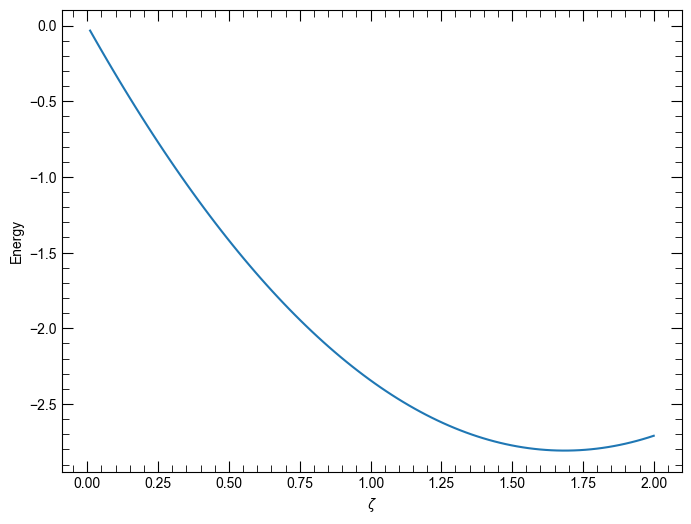

In [12]:
def total_energy(zeta, alphas, cs_new, RA):
    return 2 * energy_1e(zeta, alphas, cs_new, RA) + energy_2e(zeta, alphas, cs_new, RA)


RA = np.array([0.0, 0.0, 0.0])
zetas = np.linspace(0.01, 2, 100)
energy_values = [total_energy(zeta, alphas, cs_new, RA) for zeta in zetas]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(zetas, energy_values)
ax.set_xlabel(r"$\zeta$")
ax.set_ylabel("Energy")
plt.show()

In [13]:
minimize(lambda zeta: total_energy(zeta, alphas, cs_new, RA), 1.0, method="Nelder-Mead")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -2.8078341148927795
             x: [ 1.685e+00]
           nit: 16
          nfev: 32
 final_simplex: (array([[ 1.685e+00],
                       [ 1.685e+00]]), array([-2.808e+00, -2.808e+00]))